In [1]:
import os
from google.colab import userdata
import zipfile
import cv2
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

import random

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50

from tensorflow.keras.optimizers import Adam

os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')

!mkdir -p ~/.kaggle
!echo '{"username":"'${KAGGLE_USERNAME}'","key":"'${KAGGLE_KEY}'"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
DRIVE_PATH = "/content/drive/MyDrive/Deep Learning"
ZIP_FILE = f"{DRIVE_PATH}/chest-xray-pneumonia.zip"
LOCAL_DATA_PATH = "/content/data"

if not os.path.exists(LOCAL_DATA_PATH):
    print("The dataset is being extracted to the local disk (for quick training)...")
    with zipfile.ZipFile(ZIP_FILE, 'r') as zip_ref:
        zip_ref.extractall(LOCAL_DATA_PATH)
    print("Extraction complete.")
else:
    print("The dataset is already available on the local disk.")

BASE_PATH = os.path.join(LOCAL_DATA_PATH, "chest_xray")

The dataset is being extracted to the local disk (for quick training)...
Extraction complete.


In [3]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_dir = os.path.join(BASE_PATH, 'train')
val_dir = os.path.join(BASE_PATH, 'val')
test_dir = os.path.join(BASE_PATH, 'test')

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [29]:
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))


    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'go-', label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'go-', label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.legend()

    plt.show()


Training Set - Normal: 1341
Training Set - Pneumonia: 3875


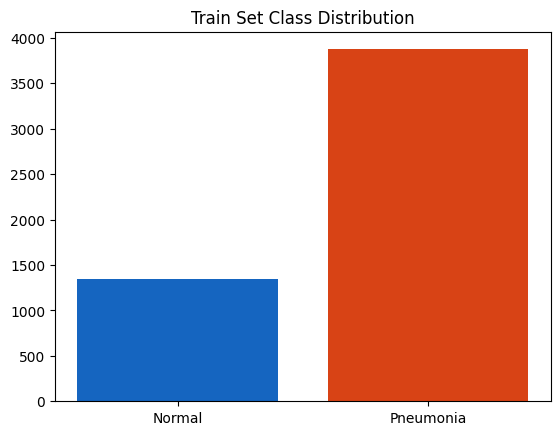

In [4]:
def count_files(directory):
    return len([f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))])

train_normal = count_files(os.path.join(train_dir, 'NORMAL'))
train_pneu = count_files(os.path.join(train_dir, 'PNEUMONIA'))

print(f"Training Set - Normal: {train_normal}")
print(f"Training Set - Pneumonia: {train_pneu}")


plt.bar(['Normal', 'Pneumonia'], [train_normal, train_pneu], color=['#1565C0', '#D84315'])
plt.title('Train Set Class Distribution')
plt.show()

/tmp/ipython-input-1531529208.py:4: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  plt.hist(sample_img.ravel(), 256, [0,256])


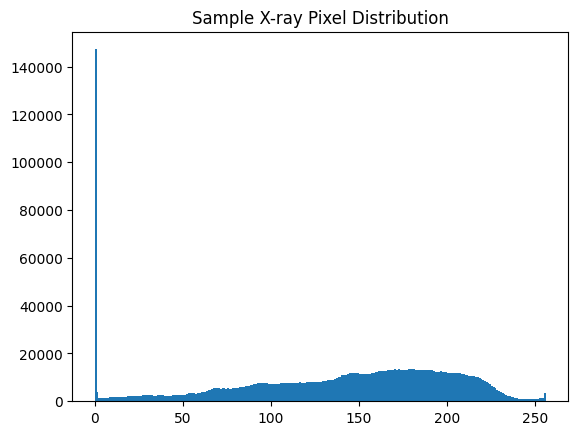

In [5]:
sample_img_path = os.path.join(train_dir, 'NORMAL', os.listdir(os.path.join(train_dir, 'NORMAL'))[0])
sample_img = cv2.imread(sample_img_path, cv2.IMREAD_GRAYSCALE)

plt.hist(sample_img.ravel(), 256, [0,256])
plt.title('Sample X-ray Pixel Distribution')
plt.show()

In [6]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,168,513 (42.60 MB)

 Trainable params: 11,168,513 (42.60 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
total_samples = 1341 + 3875
weight_for_0 = (1 / 1341) * (total_samples / 2.0)
weight_for_1 = (1 / 3875) * (total_samples / 2.0)

class_weights = {0: weight_for_0, 1: weight_for_1}

print(f"Normal Class Weight: {weight_for_0:.2f}")
print(f"Pneumonia Class Weight: {weight_for_1:.2f}")

Normal Class Weight: 1.94
Pneumonia Class Weight: 0.67


In [8]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=[early_stop]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 55s 294ms/step - accuracy: 0.7070 - loss: 0.5726 - val_accuracy: 0.8750 - val_loss: 0.4800
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 48s 294ms/step - accuracy: 0.8555 - loss: 0.3324 - val_accuracy: 0.7500 - val_loss: 0.6503
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 47s 290ms/step - accuracy: 0.8927 - loss: 0.2465 - val_accuracy: 0.8125 - val_loss: 0.5276
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 47s 288ms/step - accuracy: 0.8911 - loss: 0.2337 - val_accuracy: 0.8125 - val_loss: 0.5818
Epoch 4: early stopping


In [9]:
test_results = model.evaluate(test_generator)
print(f"Test Loss: {test_results[0]}")
print(f"Test Accuracy: {test_results[1]}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.7691 - loss: 0.5041
Test Loss: 0.35562998056411743
Test Accuracy: 0.8445512652397156


In [10]:
predictions = model.predict(test_generator)
y_pred = (predictions > 0.5).astype("int32")

y_true = test_generator.classes

print(classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA']))

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step
              precision    recall  f1-score   support

      NORMAL       0.86      0.70      0.77       234
   PNEUMONIA       0.84      0.93      0.88       390

    accuracy                           0.84       624
   macro avg       0.85      0.82      0.83       624
weighted avg       0.85      0.84      0.84       624



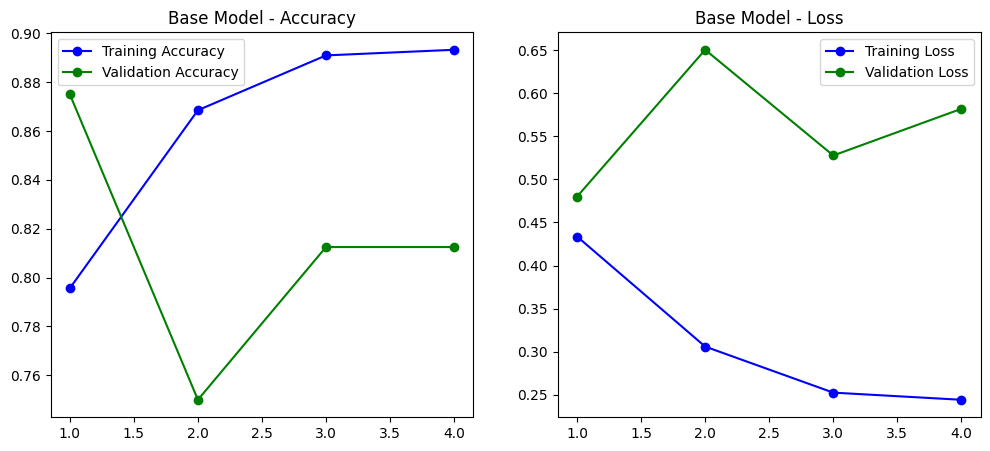

In [31]:
plot_history(history, "Base Model")

## New Generator Defining For VGG & Resnet Architecture

In [11]:
train_generator2 = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    shuffle=True
)

val_generator2 = val_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)

test_generator2 = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## VGG16 Architecture

In [12]:
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

vgg_base.trainable = False

model_vgg = models.Sequential([
    vgg_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model_vgg.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_vgg.summary()

history_vgg = model_vgg.fit(
    train_generator2,
    epochs=10,
    validation_data=val_generator2,
    class_weight=class_weights,
    callbacks=[early_stop]
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,481 (56.38 MB)

 Trainable params: 65,793 (257.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 108s 589ms/step - accuracy: 0.7200 - loss: 0.5357 - val_accuracy: 0.7500 - val_loss: 0.3697
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 91s 558ms/step - accuracy: 0.8839 - loss: 0.2893 - val_accuracy: 0.7500 - val_loss: 0.4879
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 91s 560ms/step - accuracy: 0.9082 - loss: 0.2379 - val_accuracy: 0.8125 - val_loss: 0.3691
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 92s 561ms/step - accuracy: 0.9130 - loss: 0.2233 - val_accuracy: 0.8125 - val_loss: 0.3568
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 92s 564ms/step - accuracy: 0.9146 - loss: 0.2138 - val_accuracy: 0.7500 - val_loss: 0.3588
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 91s 556ms/step - accuracy: 0.9298 - loss: 0.1868 - val_accuracy: 0.8125 - val_loss: 0.2993
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 91s 558ms/step - accuracy: 0.9242 - loss: 0.1880 - val_accuracy: 0.8125 - val_loss: 0.2967
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 92s 565ms/step - accuracy: 0.9258 - loss: 

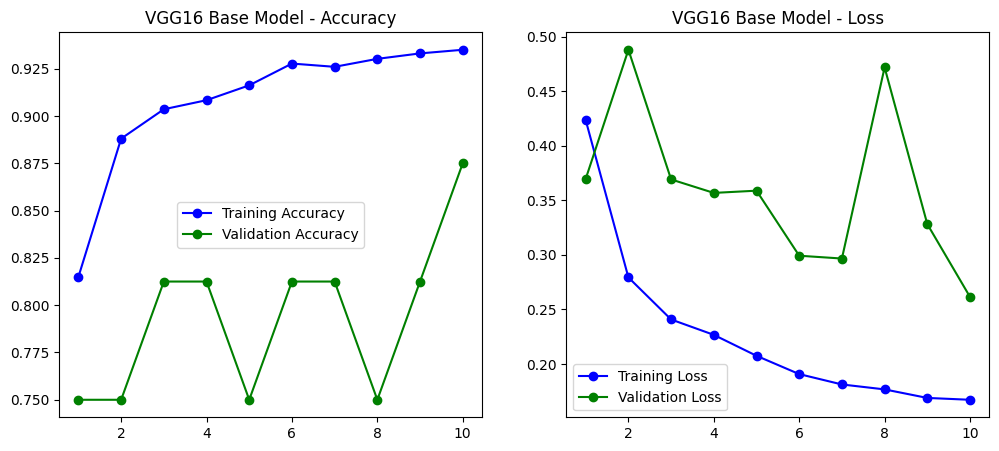

In [32]:
plot_history(history_vgg, "VGG16 Base Model")

## Resnet Architecture

In [13]:

resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

resnet_base.trainable = False

model_resnet = models.Sequential([
    resnet_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model_resnet.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model_resnet.summary()

history_resnet = model_resnet.fit(
    train_generator2,
    epochs=10,
    validation_data=val_generator2,
    class_weight=class_weights,
    callbacks=[early_stop]
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 111s 599ms/step - accuracy: 0.5461 - loss: 0.7239 - val_accuracy: 0.6250 - val_loss: 0.6446
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 93s 568ms/step - accuracy: 0.6715 - loss: 0.6236 - val_accuracy: 0.5625 - val_loss: 0.6469
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 92s 563ms/step - accuracy: 0.7105 - loss: 0.5819 - val_accuracy: 0.6250 - val_loss: 0.6029
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 93s 569ms/step - accuracy: 0.7700 - loss: 0.5290 - val_accuracy: 0.6250 - val_loss: 0.5650
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 91s 555ms/step - accuracy: 0.7708 - loss: 0.5043 - val_accuracy: 0.6875 - val_loss: 0.5444
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 93s 567ms/step - accuracy: 0.7766 - loss: 0.4882 - val_accuracy: 0.6250 - val_loss: 0.6374
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 92s 567ms/step - accuracy: 0.7972 - loss: 0.4713 - val_accuracy: 0.6875 - val_loss: 0.5358
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 92s 562ms/step - accuracy: 0.7730 - loss: 

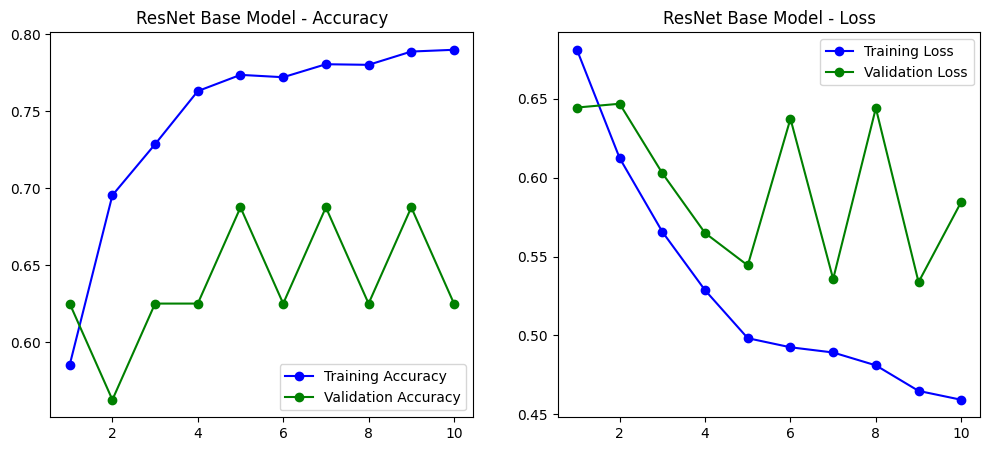

In [33]:
plot_history(history_resnet, "ResNet Base Model")

## Model Performance Comparisons

In [14]:
print("\n--- Base Model Results ---")
test_results = model.evaluate(test_generator)

print("--- VGG16 Results ---")
vgg_results = model_vgg.evaluate(test_generator2)

print("\n--- ResNet50 Results ---")
resnet_results = model_resnet.evaluate(test_generator2)


--- Base Model Results ---
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.7691 - loss: 0.5041
--- VGG16 Results ---
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 191ms/step - accuracy: 0.8969 - loss: 0.2648

--- ResNet50 Results ---
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step - accuracy: 0.7780 - loss: 0.5086


In [15]:
def evaluate_model_performance(model, generator, name):
    print(f"\n{'='*20} {name} Results {'='*20}")


    predictions = model.predict(generator)
    y_pred = (predictions > 0.5).astype("int32")
    y_true = generator.classes


    report = classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA'], output_dict=True)

    print(classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA']))
    return report['PNEUMONIA']


base_results = evaluate_model_performance(model, test_generator, "Base Model")


vgg_results = evaluate_model_performance(model_vgg, test_generator2, "VGG16")

resnet_results = evaluate_model_performance(model_resnet, test_generator2, "ResNet50")


==================== Base Model Results ====================
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step
              precision    recall  f1-score   support

      NORMAL       0.86      0.70      0.77       234
   PNEUMONIA       0.84      0.93      0.88       390

    accuracy                           0.84       624
   macro avg       0.85      0.82      0.83       624
weighted avg       0.85      0.84      0.84       624


==================== VGG16 Results ====================
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 227ms/step
              precision    recall  f1-score   support

      NORMAL       0.86      0.87      0.86       234
   PNEUMONIA       0.92      0.92      0.92       390

    accuracy                           0.90       624
   macro avg       0.89      0.89      0.89       624
weighted avg       0.90      0.90      0.90       624


==================== ResNet50 Results ====================
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 391ms/step
              precision    recall  f1-score

**1. Champion: VGG16 (90% Accuracy)**

  * VGG16 is currently our most successful and balanced model.

  * Pneumonia Recall (0.93): This is the most critical achievement from a medical perspective. It correctly identified 92% of 390 patients. Only a very small percentage were missed.

  * F1-Score (0.90): It exhibits balanced performance, with the highest sensitivity and accuracy.

  * Normal Recall (0.87): The rate of false positives (calling healthy people "sick") is much lower than other models.

**2. "Guaranteed" But Misleading: Base Model (84% Accuracy)**

  * The model you built from scratch exhibited interesting behavior:

  * Pneumonia Recall (0.93): Surprisingly, the highest recall value is here! It misses almost no patients.

  * However, there's a big problem: The recall value for the NORMAL class is only 0.70.

  * **Analysis: This model behaves "safely"; it labels almost everything it sees as "PNEUMONIA". Therefore, 33% of healthy people may have been mistakenly diagnosed as ill. In a real hospital scenario, this could lead to a lot of unnecessary testing and panic.**

**3. Below Expectations: ResNet50 (80% Accuracy)**
  
  * Why did ResNet50, which is normally expected to be more powerful, fall behind?

  * Pneumonia Recall (0.81): Far behind VGG16.

  * **Analysis: ResNet is a very deep architecture. Because we froze the weights, our model may have struggled to extract meaningful features from X-ray images. Fine-tuning (opening up layers for training) is usually necessary for giants like ResNet to "wake up".**

## Fine-Tuning Phase

### Fine Tuning For VGG Model:

In [16]:
vgg_base = model_vgg.layers[0]

print(f"VGG Base Total Number of Layers: {len(vgg_base.layers)}")

for i, layer in enumerate(vgg_base.layers[-10:]):
    print(f"Layer {i}: {layer.name} - Is it trainable?: {layer.trainable}")

VGG Base Total Number of Layers: 19
Layer 0: block3_conv3 - Is it trainable?: False
Layer 1: block3_pool - Is it trainable?: False
Layer 2: block4_conv1 - Is it trainable?: False
Layer 3: block4_conv2 - Is it trainable?: False
Layer 4: block4_conv3 - Is it trainable?: False
Layer 5: block4_pool - Is it trainable?: False
Layer 6: block5_conv1 - Is it trainable?: False
Layer 7: block5_conv2 - Is it trainable?: False
Layer 8: block5_conv3 - Is it trainable?: False
Layer 9: block5_pool - Is it trainable?: False


In [17]:
vgg_base.trainable = True

set_trainable = False
for layer in vgg_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True

    if set_trainable:
        layer.trainable = True
        print(f"Trainable: {layer.name}")
    else:
        layer.trainable = False

Trainable: block5_conv1
Trainable: block5_conv2
Trainable: block5_conv3
Trainable: block5_pool


In [18]:
optimizer_fine = Adam(learning_rate=1e-5)

model_vgg.compile(
    optimizer=optimizer_fine,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\nThe model was recompiled with a low learning rate for fine-tuning..")
model_vgg.summary()


The model was recompiled with a low learning rate for fine-tuning..


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,481 (56.38 MB)

 Trainable params: 7,145,217 (27.26 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [19]:
history_vgg_fine = model_vgg.fit(
    train_generator2,
    epochs=10,
    validation_data=val_generator2,
    class_weight=class_weights,
    callbacks=[early_stop]
)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 571ms/step - accuracy: 0.9416 - loss: 0.1441 - val_accuracy: 0.9375 - val_loss: 0.1544
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 93s 568ms/step - accuracy: 0.9468 - loss: 0.1213 - val_accuracy: 0.9375 - val_loss: 0.1180
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 94s 575ms/step - accuracy: 0.9643 - loss: 0.0979 - val_accuracy: 0.8750 - val_loss: 0.1815
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 92s 564ms/step - accuracy: 0.9643 - loss: 0.0882 - val_accuracy: 0.9375 - val_loss: 0.1500
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 93s 570ms/step - accuracy: 0.9737 - loss: 0.0678 - val_accuracy: 0.9375 - val_loss: 0.1599
Epoch 5: early stopping


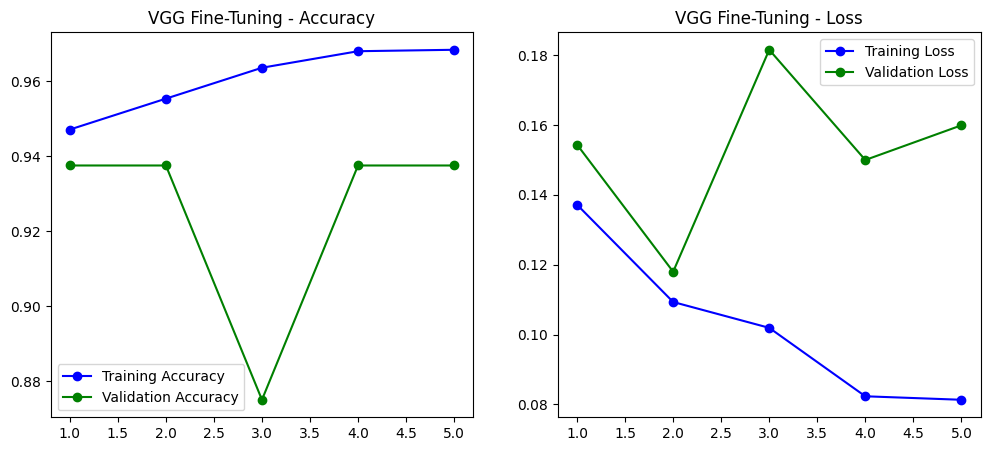

In [34]:
plot_history(history_vgg_fine, "VGG Fine-Tuning")

### Fine Tuning For ResNet Model:

In [20]:
resnet_base = model_resnet.layers[0]


resnet_base.trainable = True

set_trainable = False
for layer in resnet_base.layers:
    if layer.name == 'conv5_block1_1_conv':
        set_trainable = True

    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

print("ResNet50: The final block (Stage 5) is now open for training.")

ResNet50: The final block (Stage 5) is now open for training.


In [21]:
model_resnet.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model_resnet.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 15,238,401 (58.13 MB)

 Non-trainable params: 8,611,712 (32.85 MB)

In [22]:
history_resnet_fine = model_resnet.fit(
    train_generator2,
    epochs=10,
    validation_data=val_generator2,
    class_weight=class_weights,
    callbacks=[early_stop]
)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 116s 589ms/step - accuracy: 0.7231 - loss: 0.5646 - val_accuracy: 0.6250 - val_loss: 0.6270
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 92s 564ms/step - accuracy: 0.8548 - loss: 0.2900 - val_accuracy: 0.6875 - val_loss: 0.5392
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 91s 560ms/step - accuracy: 0.8588 - loss: 0.2851 - val_accuracy: 0.6875 - val_loss: 0.4388
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 91s 557ms/step - accuracy: 0.9045 - loss: 0.2277 - val_accuracy: 0.7500 - val_loss: 0.3863
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 91s 557ms/step - accuracy: 0.9045 - loss: 0.2153 - val_accuracy: 0.6250 - val_loss: 0.7885
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 93s 571ms/step - accuracy: 0.8953 - loss: 0.2288 - val_accuracy: 0.5625 - val_loss: 0.8799
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 93s 569ms/step - accuracy: 0.9134 - loss: 0.2146 - val_accuracy: 0.7500 - val_loss: 0.8663
Epoch 7: early stopping


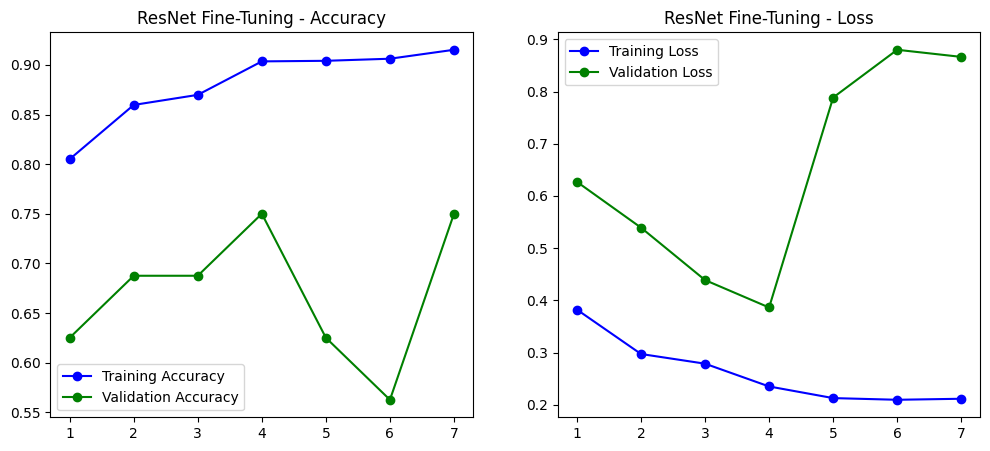

In [35]:
plot_history(history_resnet_fine, "ResNet Fine-Tuning")

## **The Final Models Comparisons: ResNet vs VGG**

In [23]:
def get_final_report(model, generator, name):
    print(f"\n--- {name} Final Test Results ---")
    preds = model.predict(generator)
    y_pred = (preds > 0.5).astype("int32")
    print(classification_report(generator.classes, y_pred, target_names=['NORMAL', 'PNEUMONIA']))


get_final_report(model_vgg, test_generator2, "VGG16 (Tuned)")

get_final_report(model_resnet, test_generator2, "ResNet50 (Tuned)")


--- VGG16 (Tuned) Final Test Results ---
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 229ms/step
              precision    recall  f1-score   support

      NORMAL       0.96      0.77      0.86       234
   PNEUMONIA       0.88      0.98      0.93       390

    accuracy                           0.90       624
   macro avg       0.92      0.88      0.89       624
weighted avg       0.91      0.90      0.90       624


--- ResNet50 (Tuned) Final Test Results ---
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 389ms/step
              precision    recall  f1-score   support

      NORMAL       0.94      0.58      0.72       234
   PNEUMONIA       0.80      0.98      0.88       390

    accuracy                           0.83       624
   macro avg       0.87      0.78      0.80       624
weighted avg       0.85      0.83      0.82       624



## **Summary** :

* **Accuracy** :

  * VGG16 : %90
  * ResNet50 : %83

    - VGG16 is clearly in the lead.

* **PNEUMONIA Recall** :

  * VGG16 : %98
  * ResNet50 : %98

    - Both are very successful at detect symptom.

* **Normal Recall** :

  * VGG16 : %77
  * ResNet50 : %58

    - The critical difference: ResNet far too often refers to healthy people as "sick."

* **F1 Score (Weighted)** :

  * VGG16 : %90
  * ResNet50 : %82

    - The VGG16 is a much more balanced model.

## **Grad-CAM HeatMap Creation :**

In [24]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    array = array / 255.0
    return array

In [25]:
def make_gradcam_heatmap(img_array, full_model, base_model_layer_name="block5_conv3"):
    vgg_base = full_model.layers[0]

    last_conv_layer = vgg_base.get_layer(base_model_layer_name)
    conv_model = tf.keras.models.Model([vgg_base.inputs], [last_conv_layer.output])

    classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer in full_model.layers[1:]:
        x = layer(x)
    classifier_model = tf.keras.models.Model(classifier_input, x)

    with tf.GradientTape() as tape:
        last_conv_layer_output = conv_model(img_array)
        tape.watch(last_conv_layer_output)
        preds = classifier_model(last_conv_layer_output)
        class_channel = preds[:, 0]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [26]:
def predict_and_visualize_gradcam(img_path, model, base_model_layer_name="block5_conv3"):

    img_size = (224, 224)
    img_array = get_img_array(img_path, img_size)


    prediction_score = model.predict(img_array)[0][0]
    label = "PNEUMONIA" if prediction_score > 0.5 else "NORMAL"
    confidence = prediction_score if label == "PNEUMONIA" else 1 - prediction_score

    print(f"\n--- Analyses Result ---")
    print(f"Image: {os.path.basename(img_path)}")
    print(f"Prediction: {label}")
    print(f"Accuracy-Score (Confidence): %{confidence*100:.2f}")


    heatmap = make_gradcam_heatmap(img_array, model, base_model_layer_name)

    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)
    jet = plt.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)


    superimposed_img = jet_heatmap * 0.4 + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img.astype('uint8') / 255.0)
    plt.title(f"Original Image\nReal Label: ???")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title(f"Grad-CAM Analysis\nModel Result: {label} (%{confidence*100:.1f})")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

Red/yellow areas are the most effective regions in the model for diagnosing pneumonia..
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

--- Analyses Result ---
Image: person93_bacteria_453.jpeg
Prediction: PNEUMONIA
Accuracy-Score (Confidence): %99.93


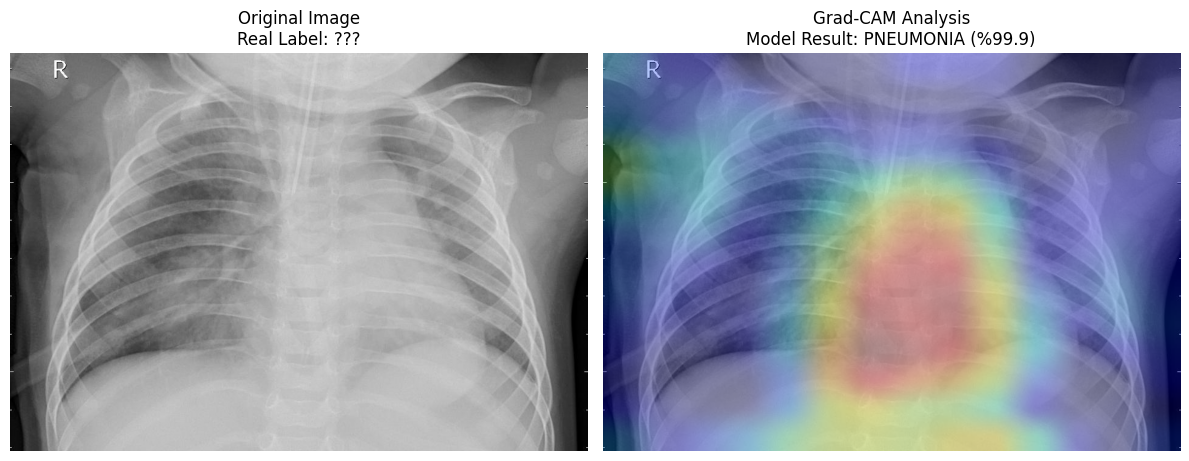

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

--- Analyses Result ---
Image: NORMAL2-IM-0292-0001.jpeg
Prediction: NORMAL
Accuracy-Score (Confidence): %95.86


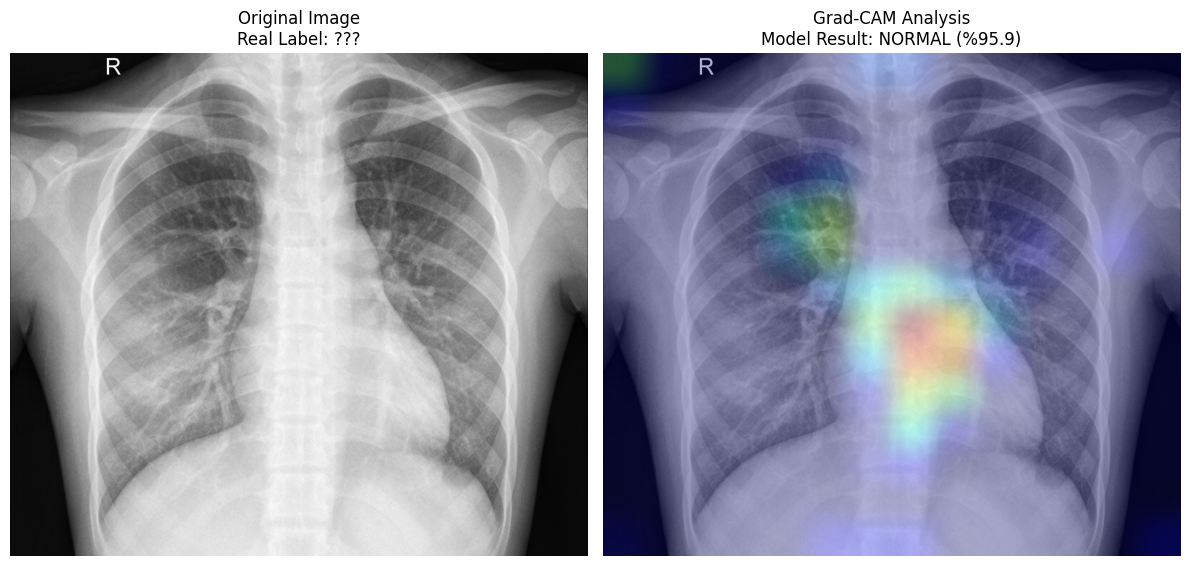

In [37]:
pneu_test_dir = os.path.join(test_dir, 'PNEUMONIA')
random_pneu_img = os.path.join(pneu_test_dir, random.choice(os.listdir(pneu_test_dir)))

normal_test_dir = os.path.join(test_dir, 'NORMAL')
random_normal_img = os.path.join(normal_test_dir, random.choice(os.listdir(normal_test_dir)))

print("Red/yellow areas are the most effective regions in the model for diagnosing pneumonia..")


predict_and_visualize_gradcam(random_pneu_img, model_vgg)


predict_and_visualize_gradcam(random_normal_img, model_vgg)

## **Model Saving**

In [28]:
model_vgg.save('/content/drive/MyDrive/Deep Learning/pneumonia_vgg16_tuned.keras')